In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import random

In [32]:
class environment_q_learning:
    def __init__(self,type_of_env:str,gamma_disc: float, epsilon:float,epsilon_decay:float,learning_rate:float,no_of_episodes:int,max_time_steps:int):

        if max_time_steps < 10:
            raise ValueError("Timesteps should be greater than of equal to 10")
        
        if (epsilon_decay > 1) or (epsilon_decay < 0):
            raise ValueError("Epsilon decay should be less than 1 and greater than 0")
        
        if no_of_episodes < 1:
            raise ValueError("No of Episodes should be atleast equal to 1")

        # No of number of states = 25 - Requirement 1
        self.environment = np.zeros((5,5))

        # No of actions an agent can take:
        self.action_set_size = 4

        self.gamma = gamma_disc
        # Q Value Learning Table
        # self. = np.zeros((len(self.environment.flatten())),self.action_set_size)
        self.qvalue_table = {}
        for i1 in range(5):
            for i2 in range(5):
                for i in np.zeros((25,4)):
                    self.qvalue_table[(i1,i2)] = i
        
        self.max_timesteps = max_time_steps
        self.current_time_steps = 0
        
        # This determines the exploitation vs exploration phase.
        self.epsilon = epsilon

        # this determines the reduction in epsilon
        self.epsilon_decay = epsilon_decay

        # this determines how quickly the q values for a state are updated
        self.learning_rate = learning_rate

        # this tells us the no_of_epsiodes during which we will determine the optimal q value
        self.no_of_episodes = no_of_episodes
        
        self.goal_pos = [4,4]
        self.agent_current_pos = [0,0]

        self.environment[tuple(self.agent_current_pos)] = 1
        self.environment[tuple(self.goal_pos)] = 0.5

        # Collection of Rewards (the keys) and associated values (the states). -> Total No of Rewards = 4 -> Requirement 3
        self.rewards = [{-1:[0,3]},{-1:[3,0]},{3:[2,3]},{3:[3,2]}]
        self.reward_states = [(0,3),(3,0),(2,3),(3,2)]
        # Setting the colors for the reward states in the environment.
        for reward_state in self.rewards:
            for reward, position in reward_state.items():
                self.environment[tuple(position)] = reward

        # Either Deterministic or stochastic.
        self.environment_type = type_of_env

        # This tracks the reward for the agent.
        self.cumulative_reward = 0

    def reset(self):
        # Here we are essentially resetting all the values.
        self.current_time_steps = 0
        self.cumulative_reward = 0

        self.goal_pos = [4,4]
        self.agent_current_pos = [0,0]
        
        self.environment = np.zeros((5,5))
        
        self.rewards = [{-1:[0,3]},{-1:[3,0]},{3:[2,3]},{3:[3,2]}]
        self.reward_states = [(0,3),(3,0),(2,3),(3,2)]
        
        for reward in self.rewards:
            for reward, position in reward.items():
                self.environment[tuple(position)] = reward

        self.environment[self.agent_current_pos] = 1
        self.environment[self.goal_pos] = 0.5
    
    def step(self):

        # We are checking wether the environment is deterministic or stochastic
        if self.environment_type == 'deterministic':
            # In Deterministic environments, there is no use for epsilon as all the actions are deterministic / greedy / pre-determined.

            self.epsilon = 0
            self.current_time_steps +=1

            # get_all_possible_actions
            all_possible_actions = self.get_all_possible_actions(self.agent_current_pos)
            # all_possible_actions -> contains a list of actions that a agent can take from the state its in
            
            states_the_actions_lead_to = self.get_states_for_actions(all_possible_actions,self.agent_current_pos)
            
            current_max = 0

            # print('IN the current states, here are the states that can be reached, ', states_the_actions_lead_to)
            
            current_max_state = states_the_actions_lead_to[0]
            current_max_states = []
            
            # all_possible_actions -> [1,3] like that a single list
            # states_the_actions_lead_to -> [[1,0],[0,1]] -> states which the all_possible_actions lead to
            for state_result, action in zip(states_the_actions_lead_to,all_possible_actions):
                
                # here we are fetching the max q value for the states that we can get into

                max_q_value_of_state = max(self.qvalue_table[tuple([state_result[0],state_result[1]])])
                
                reward = self.check_and_get_reward(state_result)
                
                q_value = reward + self.gamma * max_q_value_of_state
                
                if q_value > self.qvalue_table[tuple([state_result[0],state_result[1]])][action]:
                    print("q_value is getting updated",q_value)
                    self.qvalue_table[tuple([state_result[0],state_result[1]])][action] = q_value

                if current_max < q_value:
                    current_max_state = state_result
                    current_max = q_value
                    current_max_states = []

                elif current_max == q_value:
                    current_max_states.append(state_result)
            
            if len(current_max_states) != 0:                
                self.agent_current_pos = random.choice(current_max_states)
                # print('changing the value of agent current pos to, ',self.agent_current_pos)
            else:
                # print('changing the value of agent current pos to, ',current_max_state)
                self.agent_current_pos = current_max_state


            # # Here we are clipping the agents position to be in the environment (i.e if the agent goes out of env, we shall clip him to be inside the environment).
            # self.agent_current_pos = list(np.clip(self.agent_current_pos, 0, 4))
 
            # Here we are calculating the reward (i.e. the cumulative reward) and deleting that reward state from the collection of the reward states.
            breaker = False
            for reward_state_counter in range(len(self.rewards)):
                for reward, state in self.rewards[reward_state_counter].items():
                    # if the reward state matches the agents, sum the cum reward and delete that particular reward state space.

                    if state == self.agent_current_pos:
                        self.cumulative_reward += reward
                        del self.rewards[reward_state_counter]
                        breaker = True
                        break

                if breaker:
                    break
            
            # We are now re-visualizing the environment
            self.environment = np.zeros((5,5)) 

            for reward_state_counter in range(len(self.rewards)):
                for reward, position in self.rewards[reward_state_counter].items():
                    self.environment[tuple(position)] = reward
                
            self.environment[tuple(self.goal_pos)] = 0.5
            self.environment[tuple(self.agent_current_pos)] = 1
            
            # if the agent has reached the final state then done
            if (self.agent_current_pos == self.goal_pos) or (self.current_time_steps == self.max_timesteps):
                done_or_not = True
            
            else:
                done_or_not = False

            return self.environment.flatten, self.cumulative_reward, done_or_not, self.current_time_steps
    
    def get_state_based_on_action(self, action, state):
        if action == 0:
            # print('Up')
            state[0] -=1
            return state

        elif action == 1:
            # print('Down')
            state[0] +=1
            return state

        elif action == 2:
            # print('Our Left or the Agents Right')
            state[1] -=1
            return state

        elif action == 3:
            # print('Our Right or the Agents Left')
            state[1] +=1
            return state

    def check_and_get_reward(self, state_result):
        # print('checking rewards for, ', state_result)
        for i in range(len(self.rewards)):
        

            for key, value in self.rewards[i].items():
                if value == state_result:
                    self.rewards.pop(i)
                    print('found reward for state_result', state_result, value)
                    return key

        return 0

    # def get_all_q_values_for_states(self,all_actions,agent_state):
    def get_states_for_actions(self, all_actions, agent_state):
    
        temp_states = agent_state.copy() 
        # vals_to_be_returned = []
        states_considered = []
        for action_to_be_taken in all_actions:
            # print('states ,',temp_states)

            action_taken = self.get_state_based_on_action(action_to_be_taken,agent_state)
            states_considered.append(action_taken)
            # print(action_taken)
            
            # print(qvalue_table[action_taken[0]][action_taken[1]])
            # vals_to_be_returned.append(self.qvalue_table[action_taken[0]][action_taken[1]])
            agent_state = temp_states.copy()

        return states_considered
        # return zip(states_considered,vals_to_be_returned)

    def get_all_possible_actions(self,agent_current_pos):
        
        x_pos = agent_current_pos[0]
        y_pos = agent_current_pos[1]

        if (x_pos == 0) and (y_pos == 0):
            return [1,3]
        
        elif (x_pos == 4) and (y_pos == 0):
            return [0,3]
        
        elif (x_pos == 0) and (y_pos == 4):
            return [1,2]
        
        elif (x_pos == 0) and (y_pos <= 3):
            return [1,2,3]
        
        elif (x_pos <= 3) and (y_pos == 0 ):
            return [0,1,3]
        
        elif (x_pos == 4) and (y_pos <= 3 ):
            return [0,2,3]

        elif (x_pos < 4) and (y_pos == 4 ):
            return [0,2,1]

        elif (x_pos >=1) and (x_pos<4) and (y_pos >= 1) and (y_pos <4):
            return [0,1,2,3]

        elif (x_pos==4) and (y_pos == 4):
            return 'Yay youve won'
        else:
            return None

    def render(self):
        plt.imshow(self.environment)
        plt.show()

    def train(self):
        # done = False
        for i in range(self.no_of_episodes):
            print(i)
            done = False
            while not done:
                observation, reward, done, _ = self.step()
                if done:
                    print(reward)
                    self.render()
            self.reset()



# Sudo code for 
## Deterministic Q-Learning Value
1. Get all possible actions when ia particular state:
2. Calculate the Q-values for transistioning into the possible states (based on the actions available in step 1)
    1. Search the Q-table for the max q-values for the different states
        - If all max of all the transistion states is the same, select a random action.
    2. If there is a reward for that state, take that into consideration.
    3. Calculate the Q-values for all the actions for the state that the agent is in.
    4. Update the Q-value table for the different actions by applying the learning rate
    4. update the agent state based on the max q value in step 5.
    5. Go to step main 2
3. After we reach the goal state, reduce the gamma and the learning rate and restart the episode while keepng the epochs the same.

In [35]:
# class environment_q_learning:
#     def __init__(self,type_of_env:str,gamma_disc: float, epsilon:float,epsilon_decay:float,learning_rate:float,no_of_episodes:int,max_time_steps:int):
environment_q_learning_obj = environment_q_learning(type_of_env = 'deterministic',gamma_disc=0.9,epsilon=0.2,epsilon_decay=0.001,learning_rate=0.1,no_of_episodes=10,max_time_steps=50)

0
found reward for state_result [3, 0] [3, 0]
found reward for state_result [3, 2] [3, 2]
q_value is getting updated 3.0
q_value is getting updated 2.7
found reward for state_result [2, 3] [2, 3]
q_value is getting updated 3.0
found reward for state_result [0, 3] [0, 3]
q_value is getting updated 2.7
q_value is getting updated 2.7
q_value is getting updated 2.7
q_value is getting updated 2.7
q_value is getting updated 2.7
0


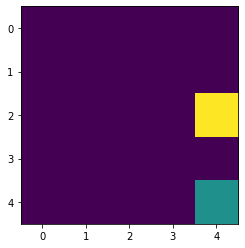

1
found reward for state_result [3, 0] [3, 0]
found reward for state_result [3, 2] [3, 2]
q_value is getting updated 5.7
q_value is getting updated 5.13
q_value is getting updated 5.13
found reward for state_result [2, 3] [2, 3]
q_value is getting updated 5.7
q_value is getting updated 5.13
q_value is getting updated 5.13
q_value is getting updated 5.13
found reward for state_result [0, 3] [0, 3]
q_value is getting updated 5.13
0


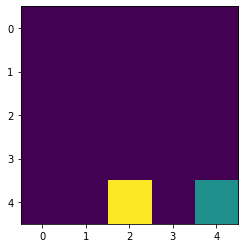

2
found reward for state_result [3, 0] [3, 0]
found reward for state_result [3, 2] [3, 2]
q_value is getting updated 8.129999999999999
q_value is getting updated 7.316999999999999
found reward for state_result [2, 3] [2, 3]
q_value is getting updated 8.129999999999999
q_value is getting updated 7.316999999999999
q_value is getting updated 7.316999999999999
q_value is getting updated 7.316999999999999
found reward for state_result [0, 3] [0, 3]
q_value is getting updated 7.316999999999999
q_value is getting updated 7.316999999999999
0


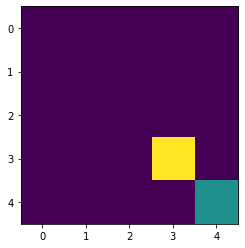

3
found reward for state_result [0, 3] [0, 3]
found reward for state_result [3, 2] [3, 2]
q_value is getting updated 10.317
found reward for state_result [2, 3] [2, 3]
q_value is getting updated 10.317
q_value is getting updated 9.285300000000001
q_value is getting updated 9.285300000000001
q_value is getting updated 9.285300000000001
q_value is getting updated 9.285300000000001
q_value is getting updated 9.285300000000001
0


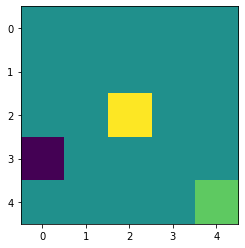

4
found reward for state_result [3, 0] [3, 0]
found reward for state_result [3, 2] [3, 2]
q_value is getting updated 12.285300000000001
q_value is getting updated 11.056770000000002
found reward for state_result [2, 3] [2, 3]
q_value is getting updated 12.285300000000001
q_value is getting updated 11.056770000000002
q_value is getting updated 11.056770000000002
found reward for state_result [0, 3] [0, 3]
q_value is getting updated 11.056770000000002
q_value is getting updated 11.056770000000002
q_value is getting updated 11.056770000000002
0


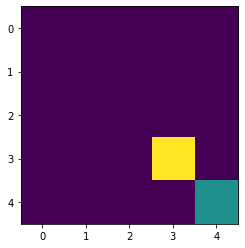

5
found reward for state_result [0, 3] [0, 3]
found reward for state_result [2, 3] [2, 3]
q_value is getting updated 14.056770000000002
q_value is getting updated 12.651093000000001
found reward for state_result [3, 2] [3, 2]
q_value is getting updated 14.056770000000002
q_value is getting updated 12.651093000000001
q_value is getting updated 12.651093000000001
q_value is getting updated 12.651093000000001
0


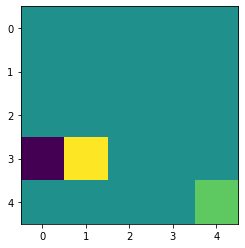

6
found reward for state_result [3, 0] [3, 0]
found reward for state_result [3, 2] [3, 2]
q_value is getting updated 15.651093000000001
found reward for state_result [2, 3] [2, 3]
q_value is getting updated 15.651093000000001
q_value is getting updated 14.085983700000002
q_value is getting updated 14.085983700000002
found reward for state_result [0, 3] [0, 3]
q_value is getting updated 14.085983700000002
q_value is getting updated 14.085983700000002
q_value is getting updated 14.085983700000002
q_value is getting updated 14.085983700000002
0


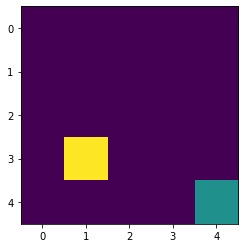

7
found reward for state_result [0, 3] [0, 3]
found reward for state_result [2, 3] [2, 3]
q_value is getting updated 17.0859837
q_value is getting updated 15.377385330000001
found reward for state_result [3, 2] [3, 2]
q_value is getting updated 17.0859837
q_value is getting updated 15.377385330000001
q_value is getting updated 15.377385330000001
0


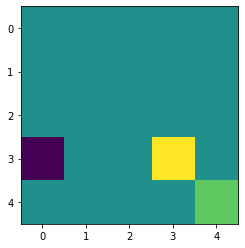

8
found reward for state_result [3, 0] [3, 0]
found reward for state_result [3, 2] [3, 2]
q_value is getting updated 18.377385330000003
found reward for state_result [2, 3] [2, 3]
q_value is getting updated 18.377385330000003
q_value is getting updated 16.539646797000003
found reward for state_result [0, 3] [0, 3]
q_value is getting updated 16.539646797000003
0


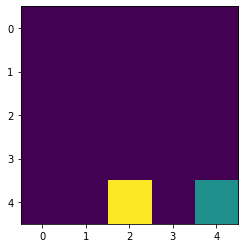

9
found reward for state_result [0, 3] [0, 3]
found reward for state_result [3, 0] [3, 0]
found reward for state_result [3, 2] [3, 2]
q_value is getting updated 19.539646797000003
found reward for state_result [2, 3] [2, 3]
q_value is getting updated 19.539646797000003
q_value is getting updated 17.585682117300003
q_value is getting updated 17.585682117300003
q_value is getting updated 17.585682117300003
q_value is getting updated 17.585682117300003
q_value is getting updated 17.585682117300003
q_value is getting updated 17.585682117300003
0


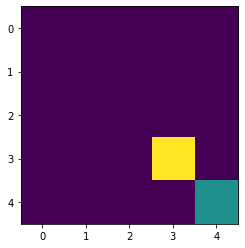

In [36]:
environment_q_learning_obj.train()

In [37]:
environment_q_learning_obj.qvalue_table

{(0, 0): array([0., 0., 0., 0.]),
 (0, 1): array([0., 0., 0., 0.]),
 (0, 2): array([0., 0., 0., 0.]),
 (0, 3): array([0., 0., 0., 0.]),
 (0, 4): array([0., 0., 0., 0.]),
 (1, 0): array([0., 0., 0., 0.]),
 (1, 1): array([0., 0., 0., 0.]),
 (1, 2): array([0., 0., 0., 0.]),
 (1, 3): array([0., 0., 0., 0.]),
 (1, 4): array([0., 0., 0., 0.]),
 (2, 0): array([0., 0., 0., 0.]),
 (2, 1): array([0., 0., 0., 0.]),
 (2, 2): array([0., 0., 0., 0.]),
 (2, 3): array([17.58568212, 17.58568212, 17.58568212, 19.5396468 ]),
 (2, 4): array([0., 0., 0., 0.]),
 (3, 0): array([0., 0., 0., 0.]),
 (3, 1): array([0., 0., 0., 0.]),
 (3, 2): array([17.58568212, 19.5396468 , 17.58568212, 17.58568212]),
 (3, 3): array([0., 0., 0., 0.]),
 (3, 4): array([0., 0., 0., 0.]),
 (4, 0): array([0., 0., 0., 0.]),
 (4, 1): array([0., 0., 0., 0.]),
 (4, 2): array([0., 0., 0., 0.]),
 (4, 3): array([0., 0., 0., 0.]),
 (4, 4): array([0., 0., 0., 0.])}